# Space Image Analysis and Modeling

This notebook analyzes and models the images contained in the Kaggle dataset [Satellite Image Classification](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification).

Table of contents:

- A

You can open this notebook in Google Colab with the following link:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mxagar/space_exploration/blob/main/space_image_classification/space_image_analysis.ipynb)



## 1. Introduction: Explore the Dataset

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
# Get the data
# This step is necessary only if you are working on Google Colab
# or if you don't have the dataset locally yet

In [3]:
# File Paths
DATA_PATH = "../data/Satellite_Image_Classification_Kaggle"
class_names = ['cloudy', 'desert', 'green_area', 'water']
# Get all image filenames
image_filenames = []
for c in class_names:
    class_image_list = []
    class_images = os.listdir(os.path.join(DATA_PATH,c))
    class_images = [os.path.join(DATA_PATH,c,img) for img in class_images if img.endswith('.jpg')]
    image_filenames.append(class_images)

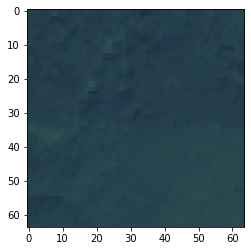

In [4]:
# Display some images
class_id = 2
image_id = 12
image_org = cv2.imread(image_filenames[class_id][image_id])
image_rgb = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [5]:
# Image size
image_rgb.shape

(64, 64, 3)

In [6]:
num_images = 0
for i, c in enumerate(class_names):
    print(f"Class {c}: {len(image_filenames[i])} images")
    num_images += len(image_filenames[i])
print(f"Total number of images: {num_images}")

Class cloudy: 1500 images
Class desert: 1131 images
Class green_area: 1500 images
Class water: 1500 images
Total number of images: 5631


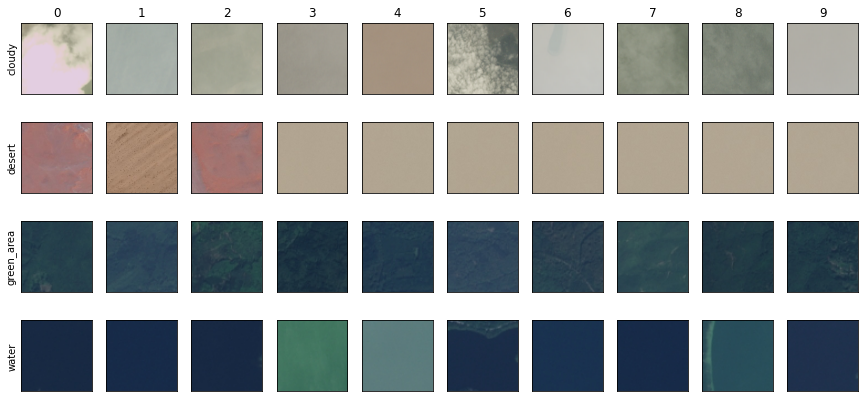

In [7]:
# Visualize 10 images for each class: rows classes, columns images ids in a class
num_images_class = 10
fig = plt.figure(figsize=(15,7))
for i in range(len(image_filenames)):
    for j in range(num_images_class):
        ax = fig.add_subplot(len(image_filenames), num_images_class, (i*num_images_class)+j+1, xticks=[], yticks=[])
        image_org = cv2.imread(image_filenames[i][j])
        image_rgb = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb)
        if i == 0:
            ax.set_title(str(j))
        if j == 0:
            ax.set_ylabel(class_names[i])            

## 2. Data Loaders

In [8]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [9]:
transform = transforms.Compose([transforms.Resize(66),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

dataset = datasets.ImageFolder(DATA_PATH, transform=transform)

test_size = round(0.1 * num_images)
val_size = round(0.1 * num_images)
train_size = num_images - test_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True)

## 3. Model Definition

### 3.1 Simple CNN

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# One convolutional layer applied an 12x12 image for a regression
# - input_size = 64
# - color image: in_channles = 4
# - output size: n_classes

# Note: x has this shape: batch_size x n_channels x width x height
# Usually, the batch_size is ignored in the comments, but it is x.size(0)!

class Net(nn.Module):

    def __init__(self, n_classes):
        super(Net, self).__init__()

        # 3 input image channels
        # 32 output channels/feature maps
        # 3x3 square convolution kernel
        # W_out = (W_in + 2P - F)/S + 1
        # W_out: (input_size + 2*1 - 3)/1 + 1 = input_size
        # WATCH OUT: default padding = 0!
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Maxpool layer
        # pool with kernel_size=2, stride=2
        # output size: input_size / 2
        # Note: there is no relu after MaxPool2d!
        self.pool = nn.MaxPool2d(2, 2)

        # In: (batch, 32, 32, 32)
        # Out: (batch, 64, 32, 32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Pool: (batch, 64, 32, 32) -> (batch, 64, 16, 16)

        # In: (batch, 64, 16, 16)
        # Out: (batch, 16, 16, 16)
        self.conv3 = nn.Conv2d(64, 16, 3, padding=1)
        # Pool: (batch, 16, 16, 16) -> (batch, 16, 8, 8)

        # In: (batch, 16, 8, 8)
        # Out: (batch, 8, 8, 8)
        self.conv4 = nn.Conv2d(16, 8, 3, padding=1)
        # Pool: (batch, 8, 8, 8) -> (batch, 8, 4, 4)

        # Fully-connected layer
        # 8*8*8 input size to account for the downsampled image size after pooling
        # num_classes outputs (for n_classes of image data)
        self.fc1 = nn.Linear(8*4*4, n_classes)

    def forward(self, x):
        # Conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1) # (batch, 8*4*4)
        # Linear layer + ReLu
        x = F.relu(self.fc1(x))
        # LogSoftmax
        x = nn.LogSoftmax(dim=1)(x)

        # Final output
        return x

# Instantiate and print Net
n_classes = len(class_names) # example number of classes
net = Net(n_classes)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=4, bias=True)
)


In [11]:
# Test forward pass
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
outputs = net.forward(inputs)
_, preds = torch.max(outputs.data, dim=1)

In [12]:
print(preds)

tensor([1, 1, 1, 1])


In [13]:
print(labels)

tensor([0, 0, 1, 1])


### 3.2 Loss Function and Optimizer

In [14]:
# NLL == CrossEntropy if NLL is applied after LogSoftmax
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Detect whether we can work on CUDA GPU - otherwise, CPU
# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device: 
# input = data.to(device)
# model = MyModule(...).to(device)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 3.3 Persistence/Loading Functions

In [39]:
# Persistence/Loading functions
def save_checkpoint(filepath, model):
    torch.save(model.state_dict(), filepath)

def load_checkpoint(filepath, model):
    state = torch.load(filepath)
    # If we saved the model in a CUDA device, we need to map it to CPU
    # checkpoint = torch.load(filepath, map_location=torch.device('cpu')), or
    # checkpoint = torch.load(filepath, map_location='cpu')    
    model.load_state_dict(state)
    return model

## 4. Training

In [38]:
# Accuracy computation for validation during training
# In general, accuracy is not the best score option...
def check_accuracy(model, dataloader, device, ratio=0.5, verbose=False):
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        total_num_batches = len(dataloader)
        max_num_batches = math.floor(ratio*total_num_batches)
        b = 0
        for data in dataloader:
            images, labels = data
            # Change images & labels to device - cuda if available
            # NOTE: no resizing done, because the architecture does not require it
            # Always check the input size of the architecture (particularly in transfer learning)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            b += 1
            if b > max_num_batches:
                break
    accuracy = correct / total
    if (verbose):
        print('Accuracy of the network on {} test images: {a:2.1f} %'.format(total, a=100 * accuracy))
    return accuracy

In [17]:
def train_model(model, optimizer, criterion, train_loader, val_loader, device, num_epochs=3, print_every=4, do_validation=False, filepath="best_model.pt"):
    epochs = num_epochs
    print_every = print_every
    steps = 0
    # Change model to device - cuda if available
    model.to(device)
    model.train()
    loss_values = []
    accuracy_values = []
    best_score = 0
    for e in range(epochs):
        running_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            steps += 1        
            # Change images & labels to device - cuda if available
            # NOTE: no resizing done, because the architecture does not require it
            # Always check the input size of the architecture (particularly in transfer learning)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Forward and backward passes
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            #loss.requires_grad = True
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                running_loss = running_loss/print_every
                loss_values.append(running_loss)
                if (do_validation):
                    model.eval() # validation & inference: always eval(), otherwise dropout is active!
                    accuracy = check_accuracy(model, dataloader=val_loader, device=device, ratio=0.5, verbose=False)
                    accuracy_values.append(accuracy)
                    if accuracy > best_score:
                        best_score = accuracy
                        save_checkpoint(filepath, model)
                    print("Epoch: {}/{}... ".format(e+1, epochs),
                          "Loss: {:.4f}".format(running_loss),
                          ", Accuracy: {:.4f}".format(accuracy))
                    model.train()
                else:
                    print("Epoch: {}/{}... ".format(e+1, epochs),
                          "Loss: {:.4f}".format(running_loss))                    
                # reset
                running_loss = 0
    print('Finished training!')
    return loss_values, accuracy_values

In [18]:
# TRAIN!
loss_values, accuracy_values = train_model(net,
                                           optimizer=optimizer,
                                           criterion=criterion,
                                           train_loader=train_loader,
                                           val_loader=val_loader,
                                           device=device,
                                           num_epochs=5,
                                           print_every=200,
                                           do_validation=True)

Epoch: 1/5...  Loss: 0.7532 , Accuracy: 0.6901
Epoch: 1/5...  Loss: 0.5279 , Accuracy: 0.7324
Epoch: 1/5...  Loss: 0.4760 , Accuracy: 0.7394
Epoch: 1/5...  Loss: 0.4766 , Accuracy: 0.7641
Epoch: 1/5...  Loss: 0.4606 , Accuracy: 0.6514
Epoch: 2/5...  Loss: 0.1767 , Accuracy: 0.7711
Epoch: 2/5...  Loss: 0.4828 , Accuracy: 0.6831
Epoch: 2/5...  Loss: 0.4489 , Accuracy: 0.6303
Epoch: 2/5...  Loss: 0.4667 , Accuracy: 0.8028
Epoch: 2/5...  Loss: 0.4521 , Accuracy: 0.6444
Epoch: 2/5...  Loss: 0.4196 , Accuracy: 0.7958
Epoch: 3/5...  Loss: 0.3380 , Accuracy: 0.7887
Epoch: 3/5...  Loss: 0.3642 , Accuracy: 0.7852
Epoch: 3/5...  Loss: 0.3893 , Accuracy: 0.8697
Epoch: 3/5...  Loss: 0.3346 , Accuracy: 0.9049
Epoch: 3/5...  Loss: 0.3499 , Accuracy: 0.8521
Epoch: 4/5...  Loss: 0.0339 , Accuracy: 0.8803
Epoch: 4/5...  Loss: 0.3144 , Accuracy: 0.8239
Epoch: 4/5...  Loss: 0.3373 , Accuracy: 0.8486
Epoch: 4/5...  Loss: 0.3163 , Accuracy: 0.9085
Epoch: 4/5...  Loss: 0.3295 , Accuracy: 0.9085
Epoch: 4/5...

### 4.1 Visualize Training Results

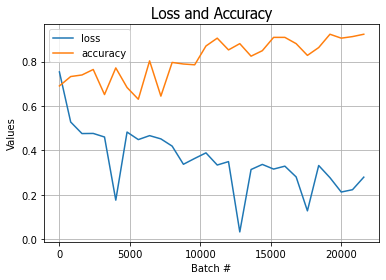

In [19]:
# Plot loss and accuracy diagrams
x = np.arange(len(loss_values))*200*4
plt.plot(x, loss_values, x, accuracy_values)
plt.xlabel('Batch #')
plt.ylabel('Values')
plt.title('Loss and Accuracy', fontname = 'Tahoma', fontsize = 15)
plt.legend(('loss', 'accuracy'), loc = 'upper left')
plt.grid(True)
plt.savefig('./training_diagram.pdf')
plt.savefig('./training_diagram.png')
plt.show()

## 5. Evaluate

In [56]:
# Load saved best model
net = Net(n_classes)
net = load_checkpoint("./best_model.pt", net_)

In [57]:
def visualize_classify(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval() # validation & inference: always eval(), otherwise dropout is active!
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))
    normalize = True

    with torch.no_grad():
        dataiter = iter(dataloader)
        inputs, labels = next(dataiter)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        _, preds = torch.max(outputs.data, dim=1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]],class_names[labels[j]]))
            image = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
            if normalize:
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                image = std * image + mean
                image = np.clip(image, 0, 1)     
            plt.imshow(image)
            if images_so_far == num_images:
                model.train(mode=was_training)
                break
        model.train(mode=was_training)

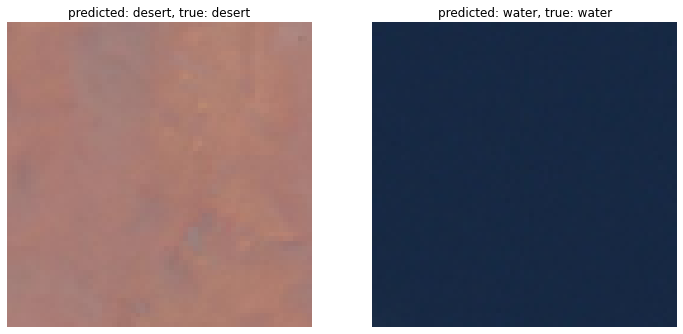

In [58]:
# Predict and visualize some examples
visualize_classify(net_, dataloader=test_loader, class_names=class_names, num_images=2)

In [59]:
def infer(model, dataloader, device):
    correct = 0
    total = 0
    model.to(device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Change images & labels to device - cuda if available
            # NOTE: no resizing done, because the architecture does not require it
            # Always check the input size of the architecture (particularly in transfer learning)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            y_true = y_true + list(predicted.cpu().numpy())
            y_pred = y_pred + list(labels.cpu().numpy())
    
    return y_true, y_pred

In [60]:
# Test split
y_true, y_pred = infer(net_, test_loader, device)

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve #, plot_roc_curve

In [62]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       146
           1       0.95      0.97      0.96       106
           2       0.93      0.91      0.92       172
           3       0.89      0.91      0.90       139

    accuracy                           0.93       563
   macro avg       0.94      0.94      0.94       563
weighted avg       0.93      0.93      0.93       563



In [63]:
# Train split
y_true, y_pred = infer(net_, train_loader, device)

In [64]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1225
           1       0.96      0.98      0.97       904
           2       0.90      0.88      0.89      1179
           3       0.88      0.89      0.89      1197

    accuracy                           0.93      4505
   macro avg       0.93      0.93      0.93      4505
weighted avg       0.93      0.93      0.93      4505



In [65]:
class_names

['cloudy', 'desert', 'green_area', 'water']

## 6. Inference Functions